In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

## Data cleaning and processing

In [13]:
import pandas as pd

# Load all CSV files
network_manager = pd.read_csv('Data/Bornholm Network Manager.csv', delimiter=';')
nordpool_price = pd.read_csv('Data/NordPool.csv', delimiter=';')
norwegian_weather = pd.read_csv('Data/Norwegian.csv', delimiter=';')
weather_observation = pd.read_csv('Data/Weather Observation.csv', delimiter=';')
energinet_price = pd.read_csv('Data/Energinet Balance price.csv', delimiter=';')

# Filter the Energinet data to only include zone DK2
filtered_energinet_price = energinet_price[energinet_price['PriceArea | PriceArea | 804696'] == 'DK2']
energinet_price = filtered_energinet_price

# Convert the 'ts' column to datetime format for each dataset
network_manager['ts'] = pd.to_datetime(network_manager['ts'], dayfirst=True)
nordpool_price['ts'] = pd.to_datetime(nordpool_price['ts'], dayfirst=True)
norwegian_weather['ts'] = pd.to_datetime(norwegian_weather['ts'], dayfirst=True)
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'], dayfirst=True)
energinet_price['ts'] = pd.to_datetime(energinet_price['ts'], dayfirst=True)

# Set 'ts' as the index for each DataFrame
network_manager.set_index('ts', inplace=True)
nordpool_price.set_index('ts', inplace=True)
norwegian_weather.set_index('ts', inplace=True)
weather_observation.set_index('ts', inplace=True)
energinet_price.set_index('ts', inplace=True)

# Resample network_manager data to hourly intervals (average the data)
network_manager_hourly = network_manager.resample('H').mean()

# Reset the index to bring 'ts' back as a regular column for merging
network_manager_hourly.reset_index(inplace=True)


C:\Users\konst\AppData\Local\Temp\ipykernel_30280\950961637.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network_manager_hourly = network_manager.resample('H').mean()


In [14]:
# Check the columns in each DataFrame
print(network_manager.columns)
# print(energinet_price.columns)
# print(nordpool_price.columns)
# print(norwegian_weather.columns)
# print(weather_observation.columns)

print(energinet_price.index)


Index(['Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133',
       'Hasle Vind Active Power | has_vin_effekt | 804123',
       'Hasle Vind Current | has_vin_belastning | 804117'],
      dtype='object')
DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-01-31 14:00:00', '2023-01-31 15:00:00',
               '2023-01-31 16:00:00', '2023-01-31 17:00:00',
               '2023-01-31 18:00:00', '2023-01-31 19:00:00',
               '2023-01-31 20:00:00', '2023-01-31 21:00:00',
               '2023-01-31 22:00:00', '2023-01-31 23:00:00'],
              dtype='datetime64[ns]', name='ts', length=744, freq=None)


In [15]:
# Merge the datasets on the 'ts' index
merged_data = network_manager_hourly.merge(nordpool_price, on='ts', how='inner')
merged_data = merged_data.merge(norwegian_weather, on='ts', how='inner')
merged_data = merged_data.merge(weather_observation, on='ts', how='inner')
merged_data = merged_data.merge(energinet_price, on='ts', how='inner')

# Handle missing data by forward filling
merged_data.fillna(method='ffill', inplace=True)

# Sort the data by the timestamp column 'ts' to ensure time order
merged_data.sort_values(by='ts', inplace=True)

# Define the feature columns (X) and the target column (y)
# For example, if 'Hasle Vind Active Power' is the target column
X = merged_data.drop(columns=['Hasle Vind Active Power | has_vin_effekt | 804123',
                              'HourDK | HourDK | 804695',
                              'HourUTC | HourUTC | 804694'])

y = merged_data['Hasle Vind Active Power | has_vin_effekt | 804123']

# Check the resulting merged data and features
print(merged_data.head())


                   ts  \
0 2023-01-02 00:00:00   
1 2023-01-02 01:00:00   
2 2023-01-02 02:00:00   
3 2023-01-02 03:00:00   
4 2023-01-02 04:00:00   

   Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133  \
0                                          10.402319                    
1                                          10.479418                    
2                                          10.473787                    
3                                          10.477362                    
4                                          10.401084                    

   Hasle Vind Active Power | has_vin_effekt | 804123  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   Hasle Vind Current | has_vin_belastning | 804117  \
0                 

C:\Users\konst\AppData\Local\Temp\ipykernel_30280\2882756237.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [68]:
print(X.columns)


Index(['ts',
       'Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133',
       'Hasle Vind Current | has_vin_belastning | 804117',
       'Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038',
       'Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820',
       'Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270',
       'Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286',
       'Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318',
       'Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302',
       'Weather forecast for wind direction at Nordhavn | 9F7J/PJ/84/MET-Norway/forecast/wind_direction | 797979',
       'Weather forecast for wind speed at Nordhavn 

In [16]:
# Step 1: Drop non-numeric columns from X
X_numeric = X.select_dtypes(include=[float, int])  # Select only numeric columns

# Step 2: Rename columns to simple names like '1', '2', ..., 'n'
X_numeric.columns = [str(i+1) for i in range(X_numeric.shape[1])]

# Step 3: Calculate the correlation matrix for the renamed feature set
correlation_matrix = X_numeric.corr()

# Step 4: Display the correlation matrix
print(correlation_matrix)

# Optional: Step 5: Visualize the correlation matrix using a heatmap for better interpretation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

plt.savefig('correlation_matrix.pdf', format="pdf")
plt.close()


           1         2         3         4         5         6         7  \
1   1.000000 -0.591349  0.522563  0.522528 -0.067936 -0.629233 -0.161451   
2  -0.591349  1.000000 -0.547147 -0.547111  0.162070  0.789863  0.136069   
3   0.522563 -0.547147  1.000000  1.000000 -0.267473 -0.603431 -0.371445   
4   0.522528 -0.547111  1.000000  1.000000 -0.267506 -0.603439 -0.371446   
5  -0.067936  0.162070 -0.267473 -0.267506  1.000000  0.107531  0.275127   
6  -0.629233  0.789863 -0.603431 -0.603439  0.107531  1.000000  0.352175   
7  -0.161451  0.136069 -0.371445 -0.371446  0.275127  0.352175  1.000000   
8  -0.246138  0.437041 -0.384246 -0.384275  0.773126  0.415440  0.284445   
9  -0.089933  0.155483 -0.278801 -0.278830  0.871755  0.095018  0.313675   
10 -0.581310  0.702615 -0.621948 -0.621926  0.085066  0.881176  0.418546   
11 -0.190768  0.352038 -0.345875 -0.345889  0.778047  0.289112  0.244061   
12 -0.153968  0.100226 -0.379436 -0.379432  0.298247  0.295591  0.963904   
13 -0.629584

High Correlation Pairs:
    Feature 1 Feature 2  Correlation
0         23        24     1.000000
1         24        23     1.000000
2         28        27     1.000000
3         27        28     1.000000
4         25        26     1.000000
5         26        25     1.000000
6          4         3     1.000000
7          3         4     1.000000
8         26        24     0.978119
9         24        26     0.978119
10        23        26     0.978116
11        26        23     0.978116
12        24        25     0.978111
13        25        24     0.978111
14        25        23     0.978109
15        23        25     0.978109
16        12         7     0.963904
17         7        12     0.963904
18        14        15     0.958854
19        15        14     0.958854
20        13         6     0.939440
21         6        13     0.939440
22        11         8     0.925935
23         8        11     0.925935
24        28         4     0.922301
25         4        28     0.922301
26 

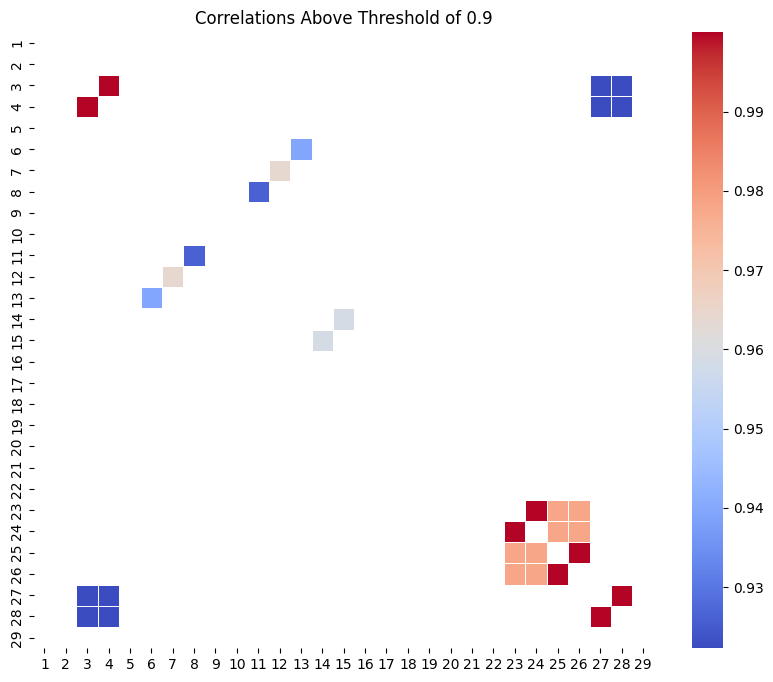

In [17]:
# Step 1: Drop non-numeric columns from X
X_numeric = X.select_dtypes(include=[float, int])  # Select only numeric columns

# Step 2: Rename columns to simple names like '1', '2', ..., 'n'
X_numeric.columns = [str(i+1) for i in range(X_numeric.shape[1])]

# Step 3: Calculate the correlation matrix for the renamed feature set
correlation_matrix = X_numeric.corr()

# Step 4: Apply a threshold to filter out correlations below the threshold (e.g., 0.9)
threshold = 0.9
high_correlation = correlation_matrix[(correlation_matrix.abs() >= threshold) & (correlation_matrix != 1.0)]

# Step 5: Display only high-correlation pairs in a more readable format
high_corr_pairs = high_correlation.stack().reset_index()
high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
high_corr_pairs = high_corr_pairs.sort_values(by="Correlation", ascending=False).reset_index(drop=True)
print("High Correlation Pairs:\n", high_corr_pairs)

# Step 6: Optional: Visualize the filtered correlations using a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(high_correlation, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=high_correlation.isnull())
plt.title(f'Correlations Above Threshold of {threshold}')
plt.show()


## Step 3

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming your data has a 'ts' column (time series or timestamp)
ts_column = X['ts']  # Extract the 'ts' column
price_Area = X['PriceArea | PriceArea | 804696']
X_features = X.drop(columns=['ts','PriceArea | PriceArea | 804696'])  # Remove 'ts' from features

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Split the data into training and testing sets (80% training, 20% testing)
# Perform a time series split: 80% for training, 20% for testing
split_index = int(0.8 * len(merged_data))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


X_train_df = pd.DataFrame(X_train, index=ts_column.index[:len(X_train)])
X_test_df = pd.DataFrame(X_test, index=ts_column.index[len(X_train):])

# Concatenate the 'ts' column to X_train and X_test
X_train = pd.concat([X_train_df, ts_column[:len(X_train)]], axis=1)
X_test = pd.concat([X_test_df, ts_column[len(X_train):]], axis=1)

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (565, 30)
Testing data shape: (142, 30)


In [19]:
# Adjusted code to plot specified features (18, 19, 20, and 28) in red

# Generate scatter plots for each feature in X_train_df against y_train
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
fig.suptitle('Scatter Plots of Each Feature in X_train_df Against y_train')

# Flatten axes for easy iteration
axes = axes.flatten()

# List of features to plot in red (0-based index for 18, 19, 20, 28 in zero-indexed Python lists)
highlight_indices = [18, 19, 20, 28]  # Adjusted to zero-based indices

for i, col in enumerate(X_train_df.columns):
    color = 'red' if i in highlight_indices else 'blue'
    axes[i].scatter(X_train_df[col], y_train, alpha=0.7, color=color)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('y_train')
    axes[i].set_title(f'{col} vs y_train')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot for visualization
plt.savefig('outlier.pdf', format="pdf")
plt.close()



In [20]:
# Dropping features 18, 19, and 20 from the training data
# Assuming features are numbered as columns in X_train_df

# Dropping the specific columns by their index (18, 19, and 20) in X_train_df and X_test_df
X_train_df_dropped = X_train_df
X_test_df_dropped = X_test_df

In [21]:
# Assuming `corr_matrix` is the correlation matrix you computed for the features
threshold = 0.9  # Define the correlation threshold

# Compute the correlation matrix (if not already done)
corr_matrix = X_train_df_dropped.corr().abs()

# Identify pairs of highly correlated features
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the highly correlated features from the dataset
X_train_df_reduced = X_train_df.drop(columns=high_corr_features)
X_test_df_reduced = X_test_df.drop(columns=high_corr_features)

# Display the features that were dropped
print("Features dropped due to high correlation:", high_corr_features)


Features dropped due to high correlation: [3, 10, 11, 12, 14, 17, 23, 24, 25, 26, 27]


In [9]:
# # Search for the columns where '57,91' appears
# mask = merged_data.apply(lambda x: x.astype(str).str.contains('57,91'))

# # Find the columns that contain the value '57,91'
# problematic_columns = mask.any(axis=0)
# columns_with_issues = merged_data.columns[problematic_columns]

# # Print the column names
# print("Columns containing '57,91':")
# print(columns_with_issues)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 3.1: Implementing Linear Regression with Gradient Descent in matrix form
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    def fit(self, X, y):
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

# Step 3.1: Implementing the closed-form solution (Normal Equation)
def closed_form_solution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best


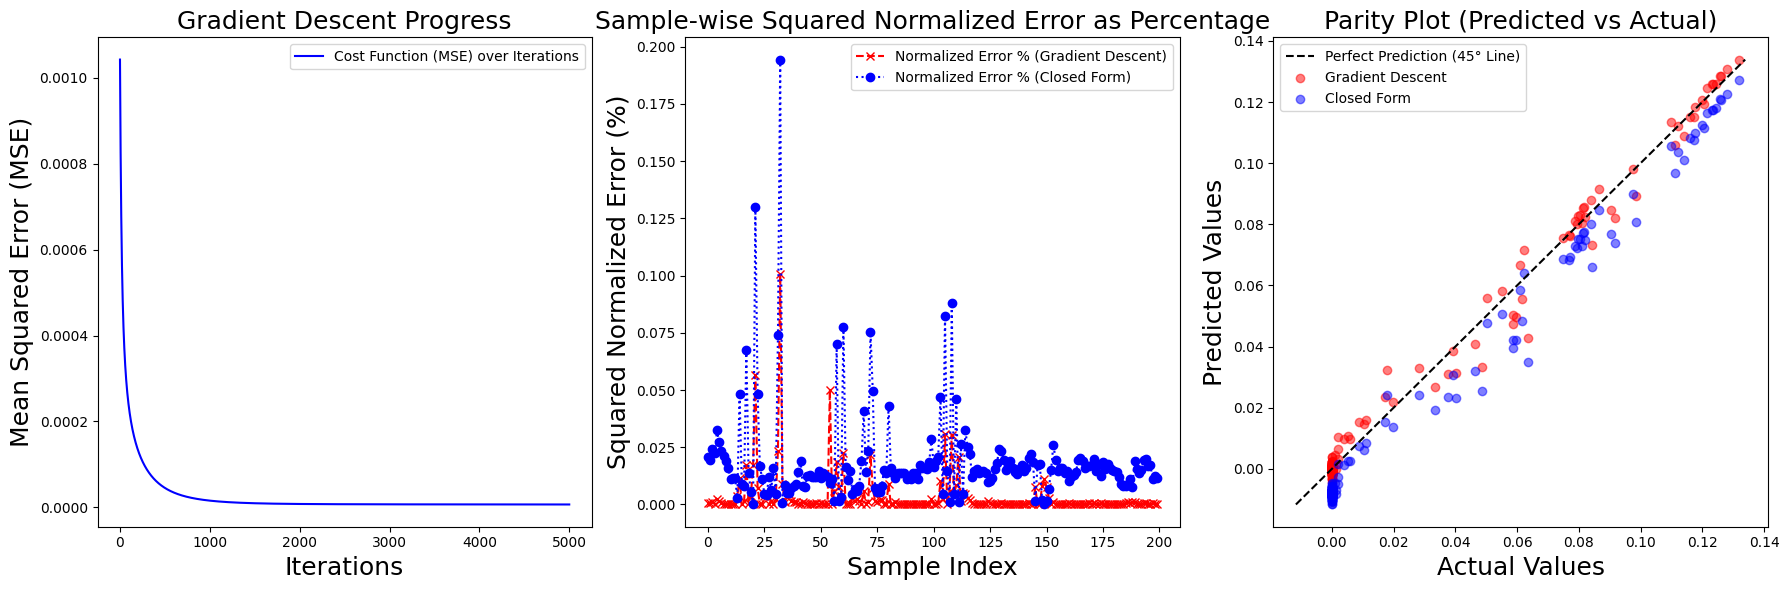

Gradient Descent Coefficients: [ 3.61774238e-02  7.24730048e-04  4.94221695e-02 -2.40713502e-04
 -7.46129320e-04  1.38659809e-03 -5.38917505e-04  2.64360978e-03
  7.28159452e-04  1.05891058e-03 -6.45664351e-04 -1.46450411e-03
 -2.74598657e-04  3.66631650e-04 -2.87884151e-03 -2.16865107e-03
 -7.24114607e-05  1.09290520e-03 -8.48654255e-04]
Closed-Form Solution Coefficients: [ 2.28137947e-01  6.56822708e-04  4.98962677e-02  2.34977504e-04
 -4.88000485e-04  4.74253106e-04  7.78594024e-04  1.49611861e-03
  2.04905797e-04  4.38123991e-04 -9.02680794e-04  6.66761199e-04
 -1.78434013e-05  2.74875559e-04  2.50250675e+00 -2.17454294e-03
 -8.67992587e-05  3.74570719e-04 -4.75212065e-04]
Are the predictions close?  False


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Step 3.1: Test on a small sample (e.g., first 100 rows)
X_train_small = np.array(X_train_df_reduced[:200], dtype=float)  # Ensure proper conversion
y_train_small = np.array(y_train[:200], dtype=float)  # Ensure proper conversion

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=5000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = closed_form_solution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
fontsize = 18

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations', fontsize=fontsize)
axs[0].set_ylabel('Mean Squared Error (MSE)', fontsize=fontsize)  # Increase font size
axs[0].set_title('Gradient Descent Progress', fontsize=fontsize)
axs[0].legend()

# Calculate sample-wise squared normalized errors as percentages
normalized_error_gd = ((y_train_small - y_pred_gd) ** 2 / np.linalg.norm(y_train_small) ** 2) * 100
normalized_error_closed_form = ((y_train_small - y_pred_closed_form) ** 2 / np.linalg.norm(y_train_small) ** 2) * 100

# Plot the squared normalized error on axs[1]
axs[1].plot(np.arange(len(normalized_error_gd)), normalized_error_gd, label='Normalized Error % (Gradient Descent)', linestyle='--', marker='x', color='r')
axs[1].plot(np.arange(len(normalized_error_closed_form)), normalized_error_closed_form, label='Normalized Error % (Closed Form)', linestyle=':', marker='o', color='b')
axs[1].set_xlabel('Sample Index', fontsize=fontsize)
axs[1].set_ylabel('Squared Normalized Error (%)', fontsize=fontsize)  # Increase font size
axs[1].set_title('Sample-wise Squared Normalized Error as Percentage', fontsize=fontsize)
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values', fontsize=fontsize)
axs[2].set_ylabel('Predicted Values', fontsize=fontsize)  # Increase font size
axs[2].set_title('Parity Plot (Predicted vs Actual)', fontsize=fontsize)
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('200samples.pdf', format="pdf")

plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form))


In [83]:
# Check mean and standard deviation of each feature after scaling
print("Means of scaled training features:", X_train_df.mean(axis=0))
print("Standard deviations of scaled training features:", X_train_df.std(axis=0))


Means of scaled training features: 0     0.034411
1    -0.104398
2     0.073242
3     0.073254
4    -0.082122
5    -0.024405
6     0.182874
7    -0.102128
8    -0.066066
9    -0.001588
10   -0.114973
11    0.177475
12   -0.049693
13    0.124940
14    0.123458
15   -0.161967
16   -0.049716
17   -0.050808
18   -0.005400
19    0.020000
20   -0.162537
21    0.082434
22    0.070088
23    0.070088
24    0.072559
25    0.072556
26    0.072961
27    0.072967
28    0.007678
dtype: float64
Standard deviations of scaled training features: 0     0.992083
1     0.936562
2     0.975325
3     0.975363
4     0.894893
5     0.997159
6     0.975910
7     0.938676
8     0.897794
9     0.987734
10    0.967621
11    0.969266
12    0.995318
13    1.041054
14    1.036718
15    0.943080
16    0.921363
17    0.896004
18    0.720566
19    1.118727
20    0.710057
21    1.031269
22    1.026227
23    1.026243
24    1.018533
25    1.018552
26    0.989734
27    0.989756
28    1.028146
dtype: float64


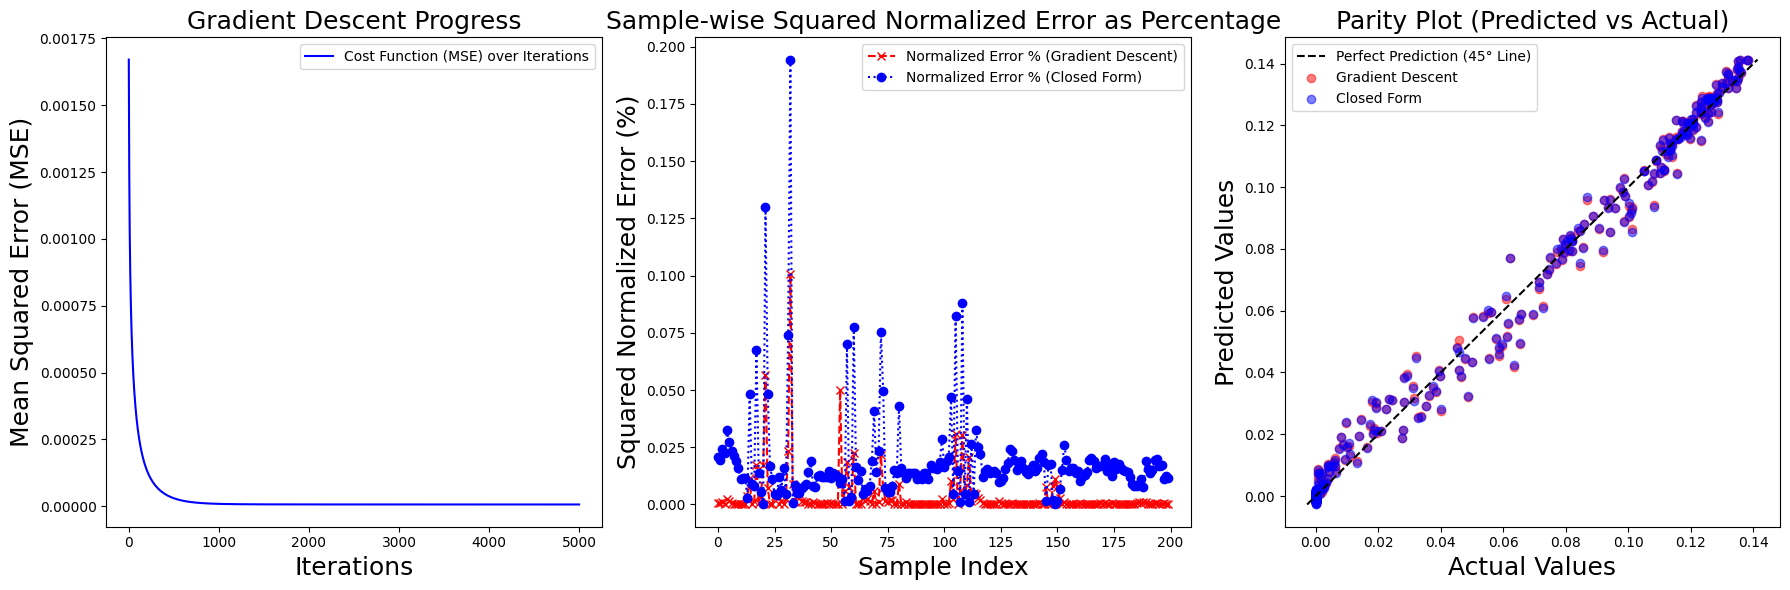

Gradient Descent Coefficients: [ 3.74143712e-02 -2.59068461e-05  5.12875263e-02  3.61333350e-04
  3.63424339e-04  1.00032373e-04  2.29831212e-04  3.94938390e-04
  1.18517753e-05  2.51664317e-04 -4.44471455e-04  2.79667843e-04
 -7.13461442e-04  7.94450247e-04  3.51714071e-04 -6.65247042e-04
 -3.53550295e-04  1.41618473e-04 -2.74023009e-04  7.97739369e-05
  1.83853653e-04 -8.48429718e-05 -2.68566126e-04  6.57958253e-04
  6.57193251e-04 -6.02214279e-04 -6.00621034e-04 -3.43980728e-04
 -3.43868223e-04 -3.73885188e-04]
Closed-Form Solution Coefficients: [ 3.74541334e-02 -1.11726494e-04  5.13944451e-02  3.81331289e-01
 -3.80198977e-01  6.78183750e-05 -2.26458012e-04  6.76480570e-04
  2.84374797e-04  2.37559247e-04 -3.58336344e-04  1.48557250e-04
 -8.05723967e-04  1.11031687e-03  5.15495832e-04 -1.19160054e-03
 -3.45229822e-04  1.49354610e-04 -3.98038839e-04  1.55191314e-04
  2.03037456e-04 -1.40456935e-04 -3.37600926e-04  3.55039930e+00
 -3.54872831e+00 -1.00755011e+00  1.00596586e+00 -6.166

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_df and y_train are defined and scaled already

# Closed-Form Solution (Normal Equation)
theta_best_full = closed_form_solution(X_train_df, y_train)
X_b_full = np.c_[np.ones((X_train_df.shape[0], 1)), X_train_df]
y_train_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=5000)  # You can increase iterations if needed
gd_model.fit(X_train_df, y_train)
y_train_pred_gd = gd_model.predict(X_train_df)

# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations', fontsize=fontsize)
axs[0].set_ylabel('Mean Squared Error (MSE)', fontsize=fontsize)
axs[0].set_title('Gradient Descent Progress', fontsize=fontsize)
axs[0].legend()

# Step 1: Calculate sample-wise squared normalized errors as percentages
normalized_error_gd = ((y_train_small - y_pred_gd) ** 2 / np.linalg.norm(y_train_small) ** 2) * 100
normalized_error_closed_form = ((y_train_small - y_pred_closed_form) ** 2 / np.linalg.norm(y_train_small) ** 2) * 100

# Step 2: Plot the squared normalized error on axs[1]
axs[1].plot(np.arange(len(normalized_error_gd)), normalized_error_gd, label='Normalized Error % (Gradient Descent)', linestyle='--', marker='x', color='r')
axs[1].plot(np.arange(len(normalized_error_closed_form)), normalized_error_closed_form, label='Normalized Error % (Closed Form)', linestyle=':', marker='o', color='b')
axs[1].set_xlabel('Sample Index', fontsize=fontsize)
axs[1].set_ylabel('Squared Normalized Error (%)', fontsize=fontsize)
axs[1].set_title('Sample-wise Squared Normalized Error as Percentage', fontsize=fontsize)
axs[1].legend()


# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_closed_form.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train, y_train_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train, y_train_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values', fontsize=fontsize)
axs[2].set_ylabel('Predicted Values', fontsize=fontsize)
axs[2].set_title('Parity Plot (Predicted vs Actual)', fontsize=fontsize)
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('Allsamples.pdf', format="pdf")

plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_train_pred_gd, y_train_pred_closed_form))


In [25]:
# Step 3.3: Evaluate the model on the testing dataset
X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test_df]
y_test_pred = X_b_test.dot(theta_best_full)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 0.003395813987562261
Mean Absolute Error (MAE): 0.002455079900494242
R-squared (R²): 0.996504224762241


## Step 4

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train_df.shape[0])  # Random weights for demonstration
model_weighted = LinearRegression()
model_weighted.fit(X_train_df, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train_df)

# Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_gd))
mae_linear = mean_absolute_error(y_train, y_train_pred_gd)
r2_linear = r2_score(y_train, y_train_pred_gd)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

rmse_weighted = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
mae_weighted = mean_absolute_error(y_train, y_train_pred_weighted)
r2_weighted = r2_score(y_train, y_train_pred_weighted)

print(f"Linear Model RMSE: {rmse_linear}")
print(f"Polynomial Model RMSE: {rmse_poly}")
print(f"Weighted Model RMSE: {rmse_weighted}")


Linear Model RMSE: 0.0037050173439423634
Polynomial Model RMSE: 9.98562539464729e-16
Weighted Model RMSE: 0.0037195818161378344


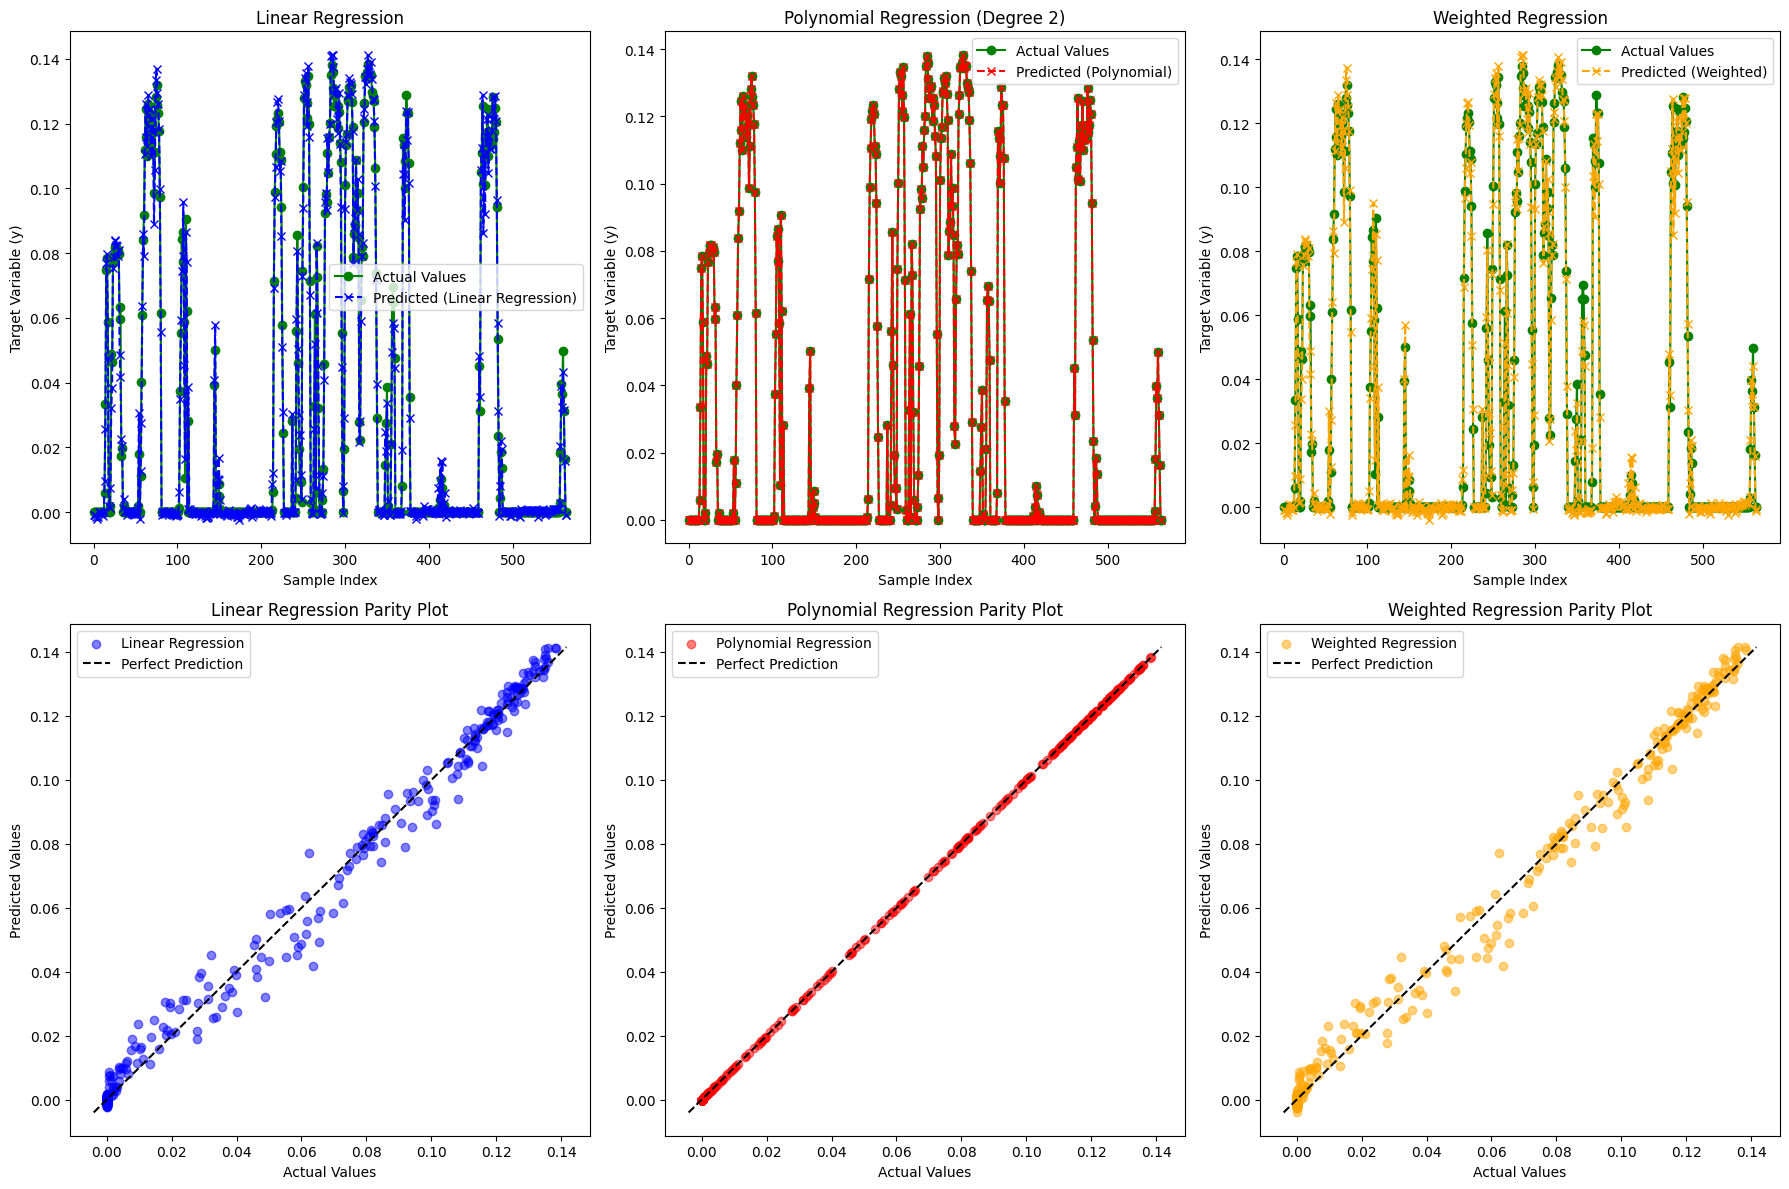

In [27]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_train_pred_gd, label='Predicted (Linear Regression)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_train_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_train_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_train, y_train_pred_gd, color='b', alpha=0.5, label='Linear Regression')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_train, y_train_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_train, y_train_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming X_train_df, y_train, and y_train_pred_gd (from the linear model) are defined

# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train_df.shape[0])  # Random weights for demonstration
model_weighted = LinearRegression()
model_weighted.fit(X_train_df, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train_df)

# Calculate normalized squared error (as percentage) for each model
normalized_error_linear = ((y_train - y_train_pred_gd) ** 2 / np.linalg.norm(y_train) ** 2) * 100
normalized_error_poly = ((y_train - y_train_pred_poly) ** 2 / np.linalg.norm(y_train) ** 2) * 100
normalized_error_weighted = ((y_train - y_train_pred_weighted) ** 2 / np.linalg.norm(y_train) ** 2) * 100

# Determine min and max for parity plot 45-degree line
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Assuming all necessary imports and data (min_val, max_val, y_train, predictions, errors) are set

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Calculate necessary elements for parity plots
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Define font size
font_size = 18

# Parity Plot: Linear Regression
file_path_linear = 'linear_regression_parity_plot.pdf'
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')
ax.scatter(y_train, y_train_pred_gd, color='r', alpha=0.5)
ax.set_xlabel('Actual Values', fontsize=font_size)
ax.set_ylabel('Predicted Values', fontsize=font_size)
ax.set_title('Parity Plot: Linear Regression', fontsize=font_size + 2)
plt.savefig(file_path_linear, format="pdf")
plt.close(fig)

# Parity Plot: Polynomial Regression
file_path_poly = 'polynomial_regression_parity_plot.pdf'
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')
ax.scatter(y_train, y_train_pred_poly, color='b', alpha=0.5)
ax.set_xlabel('Actual Values', fontsize=font_size)
ax.set_ylabel('Predicted Values', fontsize=font_size)
ax.set_title('Parity Plot: Polynomial Regression', fontsize=font_size + 2)
plt.savefig(file_path_poly, format="pdf")
plt.close(fig)

# Parity Plot: Weighted Regression
file_path_weighted = 'weighted_regression_parity_plot.pdf'
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')
ax.scatter(y_train, y_train_pred_weighted, color='g', alpha=0.5)
ax.set_xlabel('Actual Values', fontsize=font_size)
ax.set_ylabel('Predicted Values', fontsize=font_size)
ax.set_title('Parity Plot: Weighted Regression', fontsize=font_size + 2)
plt.savefig(file_path_weighted, format="pdf")
plt.close(fig)

# Evolution of Normalized Squared Error (L2 Norm)
file_path_error = 'normalized_squared_error_evolution.pdf'
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(len(normalized_error_linear)), normalized_error_linear, label='Linear Regression Error', linestyle='--', marker='x', color='r')
ax.plot(np.arange(len(normalized_error_poly)), normalized_error_poly, label='Polynomial Regression Error', linestyle=':', marker='o', color='b')
ax.plot(np.arange(len(normalized_error_weighted)), normalized_error_weighted, label='Weighted Regression Error', linestyle='-', marker='s', color='g')
ax.set_xlabel('Sample Index', fontsize=font_size)
ax.set_ylabel('Squared Normalized Error (%)', fontsize=font_size)
ax.set_title('Evolution of Normalized Squared Error (L2 Norm)', fontsize=font_size + 2)
ax.legend()
plt.savefig(file_path_error, format="pdf")
plt.close(fig)

print(f"PDFs saved as {file_path_linear}, {file_path_poly}, {file_path_weighted}, and {file_path_error}")


PDFs saved as linear_regression_parity_plot.pdf, polynomial_regression_parity_plot.pdf, weighted_regression_parity_plot.pdf, and normalized_squared_error_evolution.pdf


In [29]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# L1 Regularization (Lasso) with linear and polynomial features

# Step 5.1: L1 Regularization (Lasso) for Linear Regression
lasso_linear = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso_linear.fit(X_train_df, y_train)
y_train_pred_lasso_linear = lasso_linear.predict(X_train_df)

# Step 5.1: L1 Regularization (Lasso) for Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)

lasso_poly = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso_poly.fit(X_train_poly, y_train)
y_train_pred_lasso_poly = lasso_poly.predict(X_train_poly)

# Evaluation for both models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Linear model with L1 (Lasso)
rmse_lasso_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso_linear))
mae_lasso_linear = mean_absolute_error(y_train, y_train_pred_lasso_linear)
r2_lasso_linear = r2_score(y_train, y_train_pred_lasso_linear)

# Polynomial model with L1 (Lasso)
rmse_lasso_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso_poly))
mae_lasso_poly = mean_absolute_error(y_train, y_train_pred_lasso_poly)
r2_lasso_poly = r2_score(y_train, y_train_pred_lasso_poly)

print(f"Lasso Linear RMSE: {rmse_lasso_linear}")
print(f"Lasso Polynomial RMSE: {rmse_lasso_poly}")


Lasso Linear RMSE: 0.04818586196456606
Lasso Polynomial RMSE: 0.04818586196456606


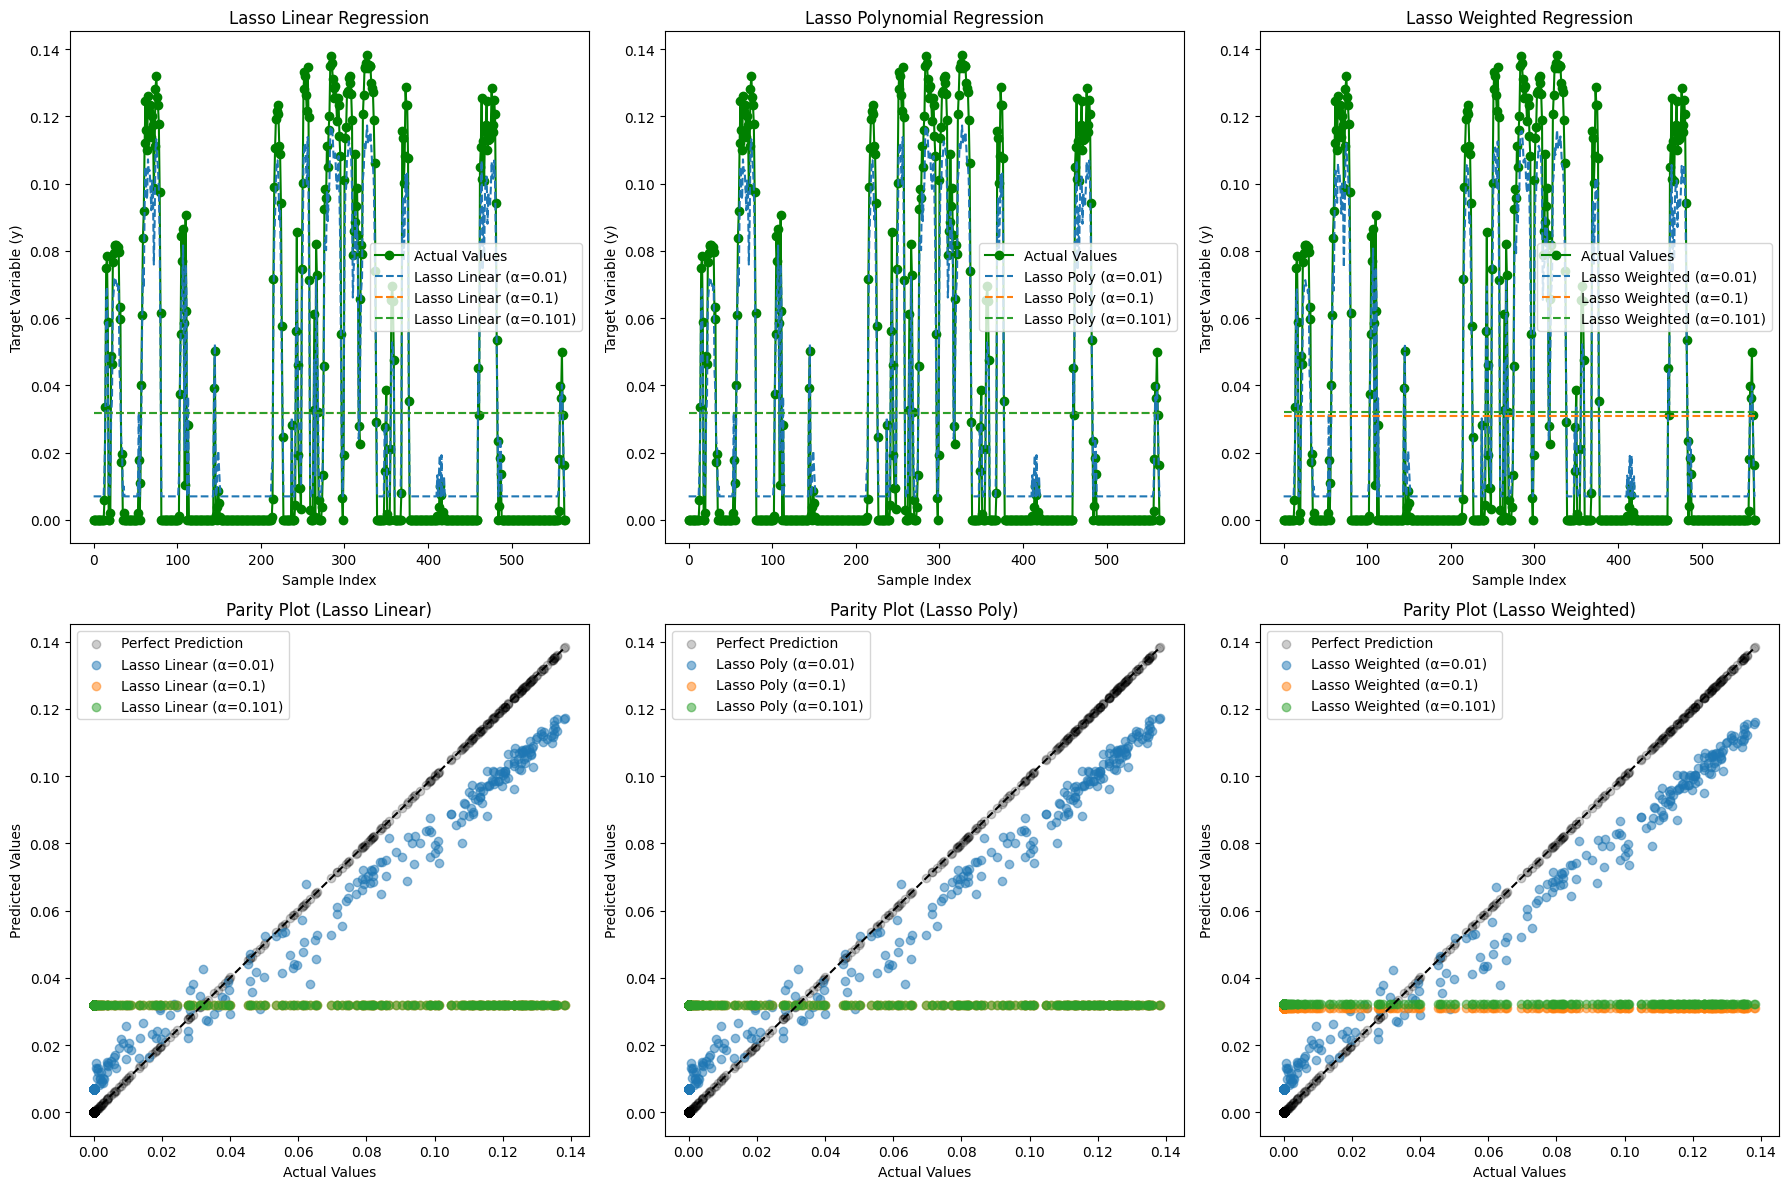

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Assuming X_train_df and y_train are already scaled and prepared
alphas = [0.01, 0.1, 0.101]

# Prepare a dictionary to store predictions for each model and alpha
predictions = {"linear": {}, "poly": {}, "weighted": {}}

# Generate predictions for different alpha values for each model
for alpha in alphas:
    # Lasso Linear Regression
    lasso_linear = Lasso(alpha=alpha)
    lasso_linear.fit(X_train_df, y_train)
    predictions["linear"][alpha] = lasso_linear.predict(X_train_df)
    
    # Lasso Polynomial Regression
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_df)
    lasso_poly = Lasso(alpha=alpha)
    lasso_poly.fit(X_train_poly, y_train)
    predictions["poly"][alpha] = lasso_poly.predict(X_train_poly)

    # Lasso Weighted Regression (simulated using sample weights)
    weights = np.random.rand(X_train_df.shape[0])  # Random weights for example
    lasso_weighted = Lasso(alpha=alpha)
    lasso_weighted.fit(X_train_df, y_train, sample_weight=weights)
    predictions["weighted"][alpha] = lasso_weighted.predict(X_train_df)

# Create a figure with six subplots (3x2): One row for Actual vs. Predicted, another for Parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values for each alpha value
# Subplot 1: Lasso Linear Regression
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
for alpha in alphas:
    axs[0, 0].plot(predictions["linear"][alpha], label=f'Lasso Linear (α={alpha})', linestyle='--')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Lasso Linear Regression')
axs[0, 0].legend()

# Subplot 2: Lasso Polynomial Regression
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
for alpha in alphas:
    axs[0, 1].plot(predictions["poly"][alpha], label=f'Lasso Poly (α={alpha})', linestyle='--')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Lasso Polynomial Regression')
axs[0, 1].legend()

# Subplot 3: Lasso Weighted Regression
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
for alpha in alphas:
    axs[0, 2].plot(predictions["weighted"][alpha], label=f'Lasso Weighted (α={alpha})', linestyle='--')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Lasso Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), *[min(predictions["linear"][alpha]) for alpha in alphas])
max_val = max(y_train.max(), *[max(predictions["linear"][alpha]) for alpha in alphas])

# Subplot 4: Parity plot for Lasso Linear Regression
axs[1, 0].scatter(y_train, y_train, color='k', alpha=0.2, label='Perfect Prediction')
for alpha in alphas:
    axs[1, 0].scatter(y_train, predictions["linear"][alpha], alpha=0.5, label=f'Lasso Linear (α={alpha})')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Parity Plot (Lasso Linear)')
axs[1, 0].legend()

# Subplot 5: Parity plot for Lasso Polynomial Regression
axs[1, 1].scatter(y_train, y_train, color='k', alpha=0.2, label='Perfect Prediction')
for alpha in alphas:
    axs[1, 1].scatter(y_train, predictions["poly"][alpha], alpha=0.5, label=f'Lasso Poly (α={alpha})')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Parity Plot (Lasso Poly)')
axs[1, 1].legend()

# Subplot 6: Parity plot for Lasso Weighted Regression
axs[1, 2].scatter(y_train, y_train, color='k', alpha=0.2, label='Perfect Prediction')
for alpha in alphas:
    axs[1, 2].scatter(y_train, predictions["weighted"][alpha], alpha=0.5, label=f'Lasso Weighted (α={alpha})')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Parity Plot (Lasso Weighted)')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [36]:
gd_model.predict(X_test_df)

array([-2.64764515e-05, -1.02335734e-03, -4.95505159e-04, -9.43300872e-04,
        7.30165741e-04,  4.97781240e-04,  3.67937851e-04,  8.65801771e-04,
        7.29282881e-04, -3.79759478e-05, -1.97016604e-04,  9.65103656e-04,
        1.45221092e-03,  1.60134678e-03,  1.45269918e-03,  1.49486093e-03,
        1.09391456e-03,  1.50940148e-03,  1.21386141e-03, -7.76287320e-04,
        4.30394076e-06, -8.29904053e-05,  4.37144522e-02,  8.62573790e-02,
        1.10188230e-01,  9.69820050e-02,  9.74358311e-02,  7.48461812e-02,
        2.54156304e-02,  1.41101883e-02,  1.48656771e-02, -3.32016420e-04,
       -1.12183470e-04, -2.93122986e-04,  1.67656261e-05,  6.11299948e-04,
        9.95788431e-04,  5.20102672e-04,  2.40336508e-04,  3.99072656e-04,
       -7.78019660e-05,  8.20250951e-05, -2.23454647e-04, -4.90985202e-05,
       -1.03798142e-04,  1.96322282e-04,  3.72368554e-04,  5.62096890e-04,
        1.55931995e-04,  6.51519007e-04,  1.36106867e-03,  3.24726406e-04,
        1.83205661e-03,  